In [ ]:
from old_source_code.data import create_joint_x_y
from quantile_regression.linear_quantile import LinearVectorQuantileRegression
import torch

device_and_dtype_specifications = {
    "device": torch.device("cpu"),
    "dtype": torch.float64
}

X, Y = create_joint_x_y(500)
X_batch = torch.from_numpy(X)
Y_batch = torch.from_numpy(Y)
X_batch = X_batch.to(**device_and_dtype_specifications)
Y_batch = Y_batch.to(**device_and_dtype_specifications)

dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_batch, Y_batch), batch_size=100, shuffle=True)

lvqr = LinearVectorQuantileRegression(num_latent_points_to_generate=600)
_ = lvqr.fit(dataloader)

# to save the model:
# lvqr.save("lvqr.pth")s

# to load the model:
# _ = lvqr.load("lvqr.pth")

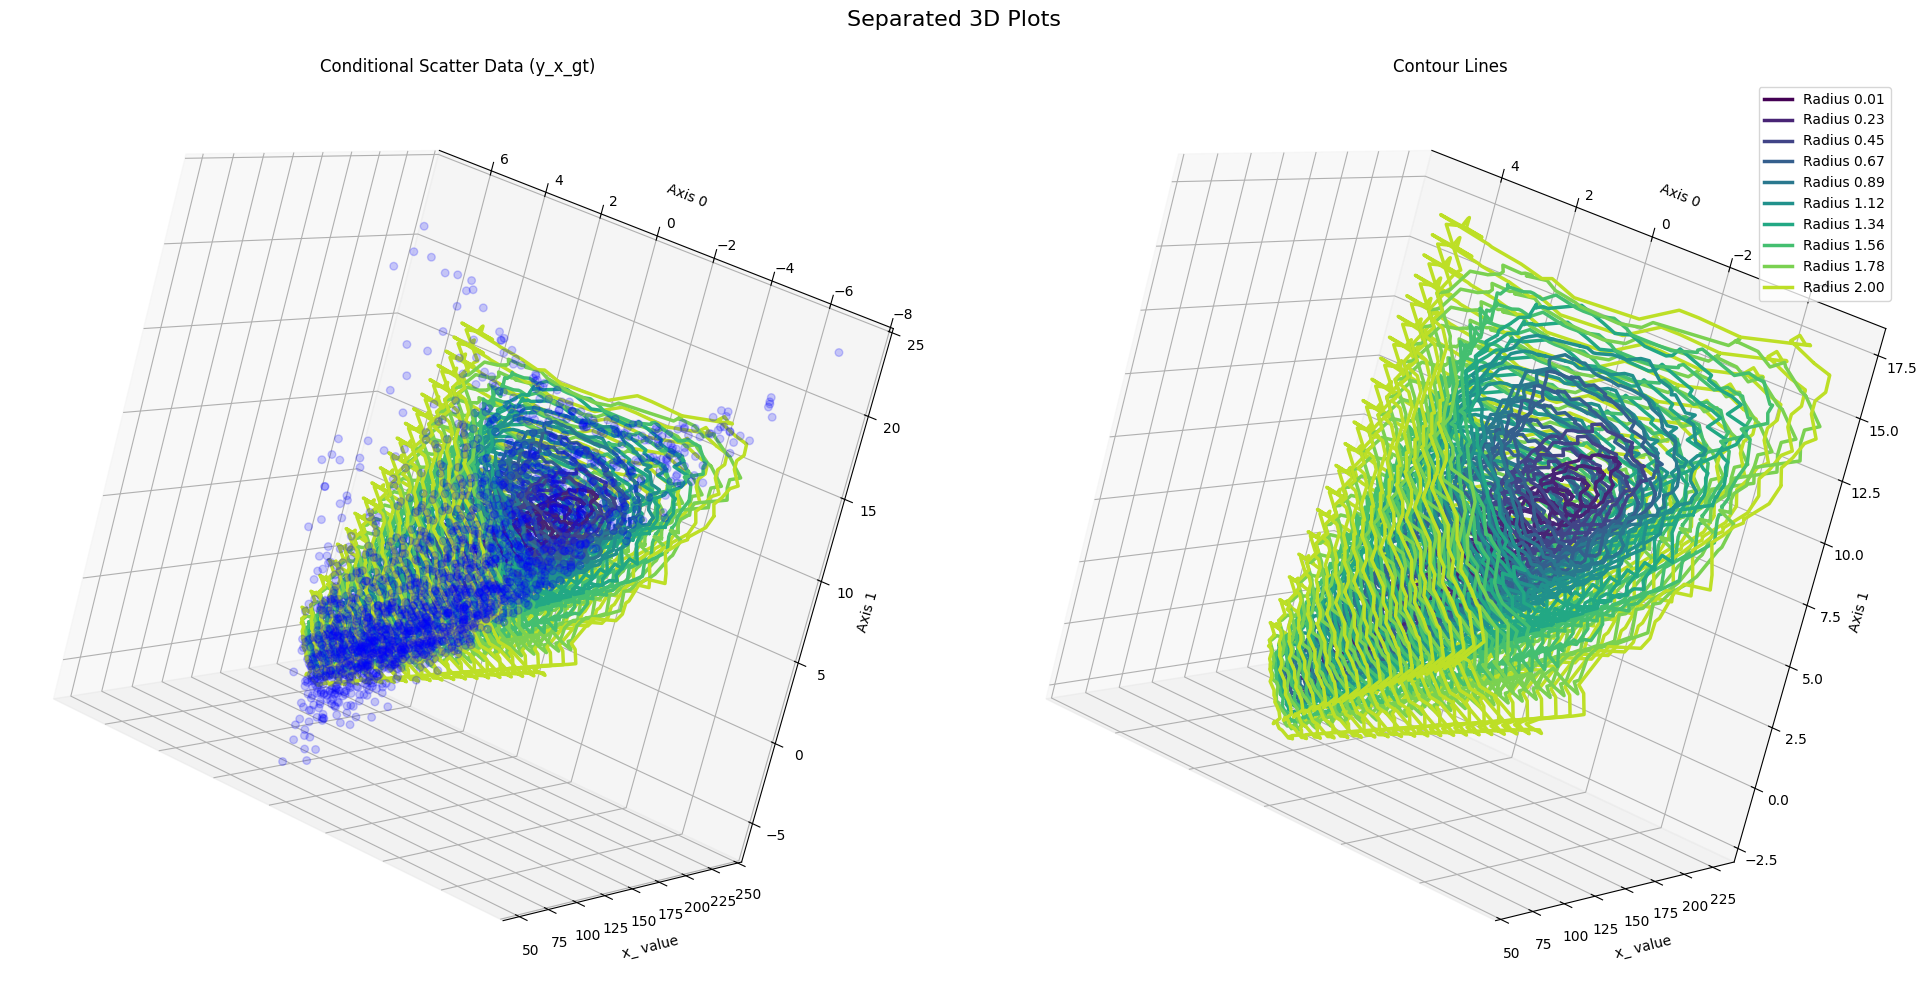

In [3]:
%matplotlib inline
from utils import plot_potentials_from_banana_dataset

plot_potentials_from_banana_dataset(model=lvqr, device_and_dtype_specifications=device_and_dtype_specifications)